In [43]:
using Plots

include("src/loader.jl")
include("src/solver.jl")
include("src/simulator.jl")
include("src/dynamic.jl")
include("src/profile_generator.jl")

filename = "data/profiles.csv";

In [44]:
period_length = 7 * 24;

if ! @isdefined(time_by_week)
    time_by_week, wind_by_week, solar_by_week = load_by_periods(filename, period_length);
end;

if ! @isdefined(time_train)
    time_train, wind_train, solar_train, time_val_full, wind_val_full, solar_val_full = 
    train_val_split(time_by_week, wind_by_week, solar_by_week);
end;

We use only the first 10 week of the validation data to make the computes faster, for now

In [45]:
T = 10
time_val = time_val_full[1:T]
wind_val = wind_val_full[1:T]
solar_val = solar_val_full[1:T];

print("Validation data: ", length(wind_val)," periods of ", period_length, " hours each\n");

Validation data: 10 periods of 168 hours each


# Dynamic Programming, simple approach
- We denote by $x^s_t$ the state of the system at time $t$, where $x^s_t$ is the current stock in the tank.
- To remove complexity, we use a discrete state space, where $x^s_t$ take values by e.g. 1/10th of the tank capacity.
- The action at time $t$ is the choice of stock level we want to reach at time $t+1$
- The cost function is given by solving the MILP problem over the period $[t,t+1]$ (e.g usually a week)
- The dynamic programming equation is given by:
$$ V_T(x^s_T) = 0 $$
$$ V_t(x^s_t) = \min_{x^s_{t+1}} \left\{ \mathbb{E}_{W^P, S^P} [C(x^s_t,x^s_{t+1}) + V_{t+1}(x^s_{t+1})] \right\} $$
where $C(x^s_t,x^s_{t+1})$ is the cost of reaching $x^s_{t+1}$ from $x^s_t$ over the period $[t,t+1]$ (given by the MILP solver)

In [46]:
N_STATES = 10 # States in tenth of the tank capacity
states = [(i / N_STATES) * TANK_CAPA for i in 0:N_STATES];
# Number of weeks used for the computation of the expected values
N_EV = 1;

In [47]:
V, policy = dynamic_solver(
    T,
    period_length = period_length,
    wind_train = wind_train,
    solar_train = solar_train,
    profiles_generator = generate_period_from_day,
    n_ev_compute = N_EV,
    states = states,
    verbose = true
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-06
Using 8 threads
Period 10
Period 9
Period 8
Period 7
Period 6
Period 5
Period 4
Period 3
Period 2
Period 1


## Policy simulator
- We can use the dynamic programming equation to simulate the effect of a given policy
- We compute the operationnal cost over a full year, and compare it to the optimal cost

In [48]:
initial_stock_index = 1
initial_stock = states[initial_stock_index]
initial_charge = 0.

print("Expected cost: $(V[initial_stock_index, 1]) €\n");

output_simulation = simulator(
    solar_val = solar_val,
    wind_val = wind_val,
    states = states,
    policy = policy,
    initial_stock = initial_stock,
    initial_charge = initial_charge,
    verbose = false
);

print("Total cost: $(output_simulation["cost"]) €\n")

Expected cost: 721335.2721863328 €
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-06
Total cost: 1.2001224146639263e7 €


In [49]:
overall_time = []

for t in 1:T
    append!(overall_time, time_val[t])
end

## Compare with the MILP solution & the no policy solution

In [50]:
output_milp = optimal(
    solar_val = solar_val,
    wind_val = wind_val,
    initial_charge = initial_charge,
    initial_stock = initial_stock,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-06


In [51]:
output_no_policy = simulator_no_policy(
    solar_val = solar_val,
    wind_val = wind_val,
    states = states,
    initial_charge = initial_charge,
    initial_stock = initial_stock,
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-06


In [52]:
policy_cost = output_simulation["cost"]
no_policy_cost = output_no_policy["cost"]
milp_cost = output_milp["operating_cost"]

policy_gap = trunc(100 * (policy_cost - milp_cost) / milp_cost, digits=2)
no_policy_gap = trunc(100 * (no_policy_cost - milp_cost) / milp_cost, digits=2)

print("Policy cost: $(policy_cost) €\n")
print("No policy cost: $(no_policy_cost) €\n")
print("MILP cost: $(milp_cost) €\n")
print("Policy gap: $policy_gap %\n")
print("No policy gap: $no_policy_gap %\n")

Policy cost: 1.2001224146639263e7 €
No policy cost: 9.464230083943656e6 €
MILP cost: 9.423788506324107e6 €
Policy gap: 27.35 %
No policy gap: 0.42 %


In [53]:
# Prepare the scatter plot of the production levels constraints
last_hour_by_period = [time_val[i][end] for i in 1:T]
# Compute the chain of action to take
action = policy[initial_stock_index, 1]
action_result_by_period = [states[action]]
for t in 2:T
    action = policy[action, t]
    append!(action_result_by_period, states[action])
end

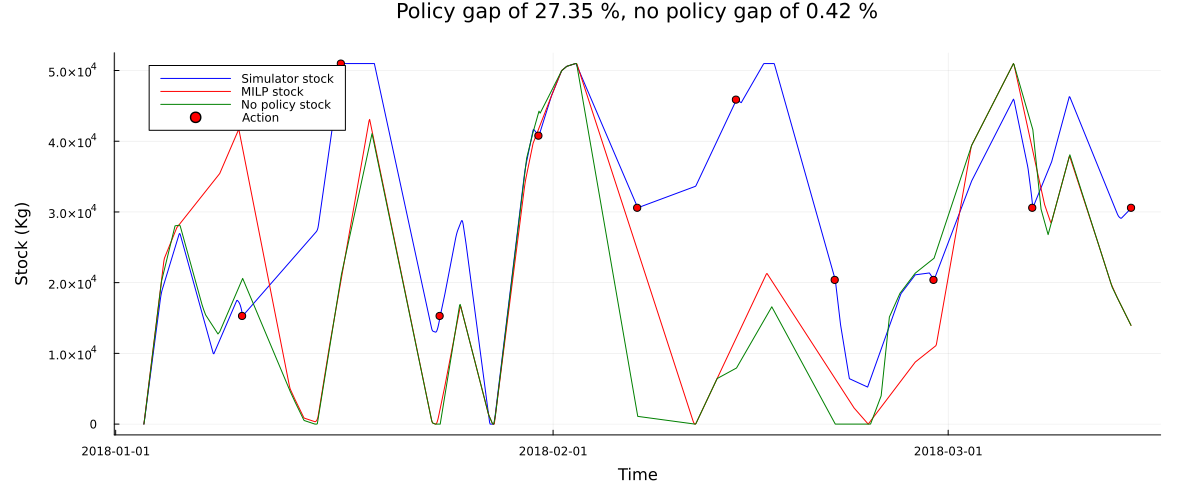

In [54]:
stock_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Stock (Kg)", title = "Policy gap of $policy_gap %, no policy gap of $no_policy_gap %")
plot!(stock_plot, overall_time,
    output_simulation["stock"], label = "Simulator stock", color = :blue) 
plot!(stock_plot, overall_time,
    output_milp["stock"][Not(end)], label = "MILP stock", color = :red)
plot!(stock_plot, overall_time,
    output_no_policy["stock"], label = "No policy stock", color = :green)

scatter!(stock_plot, last_hour_by_period, action_result_by_period, label = "Action", color = :red)

savefig(stock_plot, "plots/stock-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES).png")

plot(stock_plot)

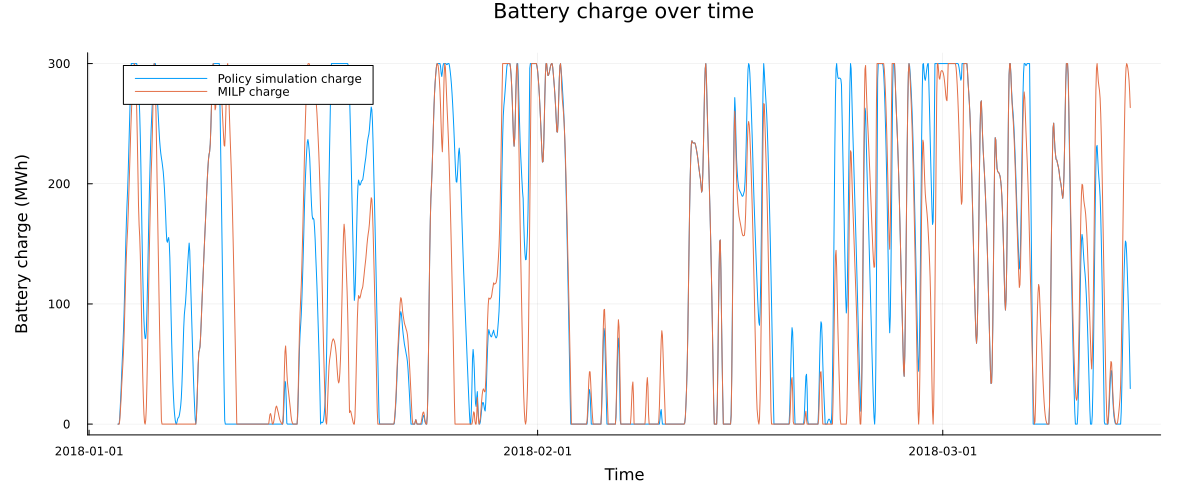

In [55]:
battery_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Battery charge (MWh)", title = "Battery charge over time")
plot!(battery_plot, overall_time, output_simulation["charge"], label = "Policy simulation charge")
plot!(battery_plot, overall_time, output_milp["charge"][Not(end)], label = "MILP charge")
savefig("plots/battery-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES).png")

plot(battery_plot)

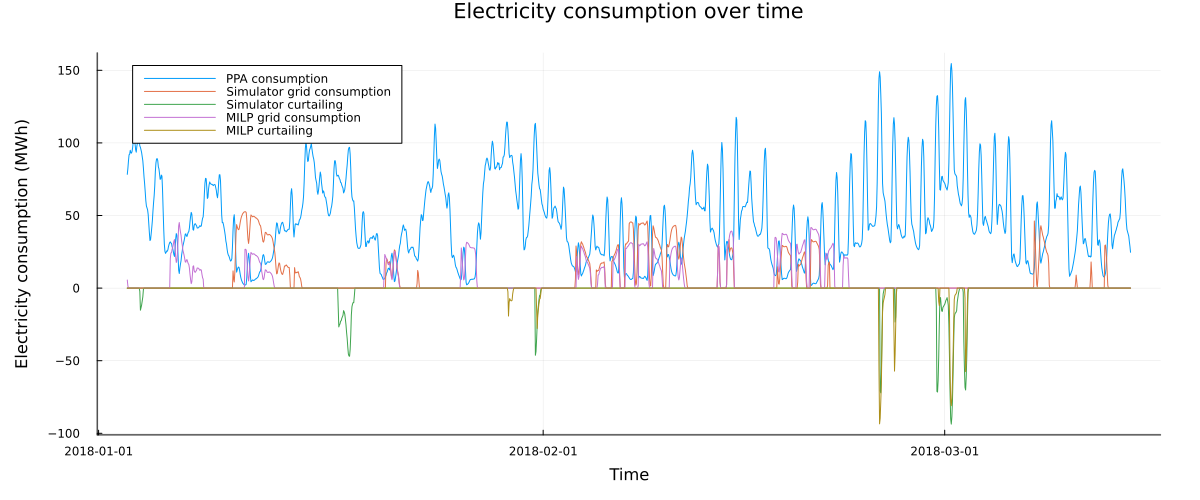

In [56]:
elec_plot = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Electricity consumption (MWh)", title = "Electricity consumption over time")
plot!(elec_plot, overall_time, output_simulation["elec_ppa"], label = "PPA consumption")
plot!(elec_plot, overall_time, output_simulation["elec_grid"], label = "Simulator grid consumption")
plot!(elec_plot, overall_time, -output_simulation["curtailing"], label = "Simulator curtailing")
plot!(elec_plot, overall_time, output_milp["elec_grid"], label = "MILP grid consumption")
plot!(elec_plot, overall_time, -output_milp["curtailing"], label = "MILP curtailing")

savefig("plots/elec-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES).png")

plot(elec_plot)

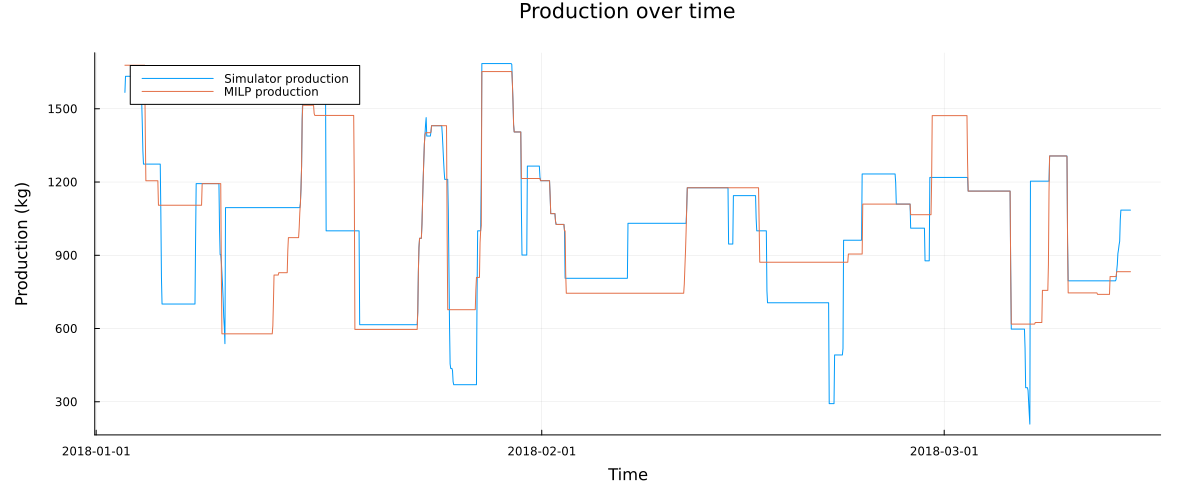

In [57]:
production = plot(size = (1200, 500), legend = :topleft, margin = 8Plots.mm,
    xlabel = "Time", ylabel = "Production (kg)", title = "Production over time")

plot!(production, overall_time, output_simulation["prod"], label = "Simulator production")
plot!(production, overall_time, output_milp["prod"], label = "MILP production")

savefig("plots/production-N_EV=$(N_EV)-T=$(T)-N_STATES=$(N_STATES).png")

plot(production)